In [ ]:
import torch.nn.utils.prune as prune
from models import CNNModel, train_loader, test_loader, raw_train_loader
import torch

# evaluates a model on the provided data_loader
def evaluate_model(model, data_loader):
	model.eval()

	correct = 0
	total_loss = 0

	criterion = torch.nn.CrossEntropyLoss()

	with torch.no_grad():
		for images, labels in data_loader:
			outputs = model(images)

			loss = criterion(outputs, labels)
			total_loss += loss.item()

			_, predicted = torch.max(outputs.data, 1)
			correct += (predicted == labels).sum().item()

	accuracy = correct / len(data_loader.dataset)

	return total_loss / len(data_loader), accuracy

def train_one_epoch(model, optimizer):
	criterion = torch.nn.CrossEntropyLoss()
	
	model.train()

	for images, labels in train_loader:
		optimizer.zero_grad()

		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

	train_loss, train_accuracy = evaluate_model(model, raw_train_loader)
	test_loss, test_accuracy = evaluate_model(model, test_loader)
	
	return train_loss, train_accuracy, test_loss, test_accuracy

def train_model(model, optimizer, num_epochs):
	# helps prevent overfitting on the small training set
	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, mode='min', patience=3)

	for epoch in range(num_epochs):
		train_loss, train_accuracy, test_loss, test_accuracy = train_one_epoch(model, optimizer)

		print(f'Epoch {epoch+1}: '
			  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
			  f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
		
		scheduler.step(test_loss)
	

def prune_model(model, sparsity):
	for _, module in model.named_modules():
		if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
			prune.l1_unstructured(module, name='weight', amount=sparsity)

	return model

def remove_pruning_masks(model):
	for _, module in model.named_modules():
		if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
			prune.remove(module, 'weight')

	return model

sparsities = [0.2, 0.5, 0.8]

for sparsity in sparsities:
	print(f'Pruning model with sparsity: {sparsity:.0%}')

	cnn_model = CNNModel()
	cnn_model.load('checkpoints/cnn-original.pt')

	pruned_model = prune_model(cnn_model, sparsity)
	remove_pruning_masks(pruned_model)
	pruned_model.save(f'checkpoints/cnn-pruned-{sparsity:.0%}.pt')

	train_loss, train_accuracy = evaluate_model(pruned_model, raw_train_loader)
	print(f'Before Fine-tuning - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
	test_loss, test_accuracy = evaluate_model(pruned_model, test_loader)
	print(f'Before Fine-tuning - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

	# reapply masks
	pruned_model = prune_model(pruned_model, sparsity)

	optimizer = torch.optim.AdamW(pruned_model.parameters(), lr=0.001, weight_decay=1e-4)
	train_model(pruned_model, optimizer, num_epochs=10)

	remove_pruning_masks(pruned_model)
	pruned_model.save(f'checkpoints/cnn-fine-tuned-{sparsity:.0%}.pt')

	train_loss, train_accuracy = evaluate_model(pruned_model, raw_train_loader)
	print(f'After Fine-tuning - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
	test_loss, test_accuracy = evaluate_model(pruned_model, test_loader)
	print(f'After Fine-tuning - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n')

Pruning model with sparsity: 20%
Before Fine-tuning - Train Loss: 0.3390, Train Accuracy: 0.8908
Before Fine-tuning - Test Loss: 0.5842, Test Accuracy: 0.7800
Epoch 1: Train Loss: 0.6958, Train Accuracy: 0.7552, Test Loss: 0.8296, Test Accuracy: 0.7200
Epoch 2: Train Loss: 0.4814, Train Accuracy: 0.8475, Test Loss: 0.7471, Test Accuracy: 0.7800
Epoch 3: Train Loss: 0.5969, Train Accuracy: 0.7753, Test Loss: 0.7255, Test Accuracy: 0.7600
Epoch 4: Train Loss: 0.5269, Train Accuracy: 0.8249, Test Loss: 0.7207, Test Accuracy: 0.7600
Epoch 5: Train Loss: 0.5135, Train Accuracy: 0.8242, Test Loss: 0.8008, Test Accuracy: 0.7200
Epoch 6: Train Loss: 0.4922, Train Accuracy: 0.8374, Test Loss: 0.6338, Test Accuracy: 0.8600
Epoch 7: Train Loss: 0.3964, Train Accuracy: 0.8638, Test Loss: 0.6786, Test Accuracy: 0.8000
Epoch 8: Train Loss: 0.6164, Train Accuracy: 0.8067, Test Loss: 0.8108, Test Accuracy: 0.6600
Epoch 9: Train Loss: 0.5028, Train Accuracy: 0.8205, Test Loss: 0.7937, Test Accuracy: 0.

Evaluating cnn-original...
Parameter Count: 141610, Non-zero Parameters: 141610
Accuracy: 82.00%
Sparsity: 0.00%
Latency: 1.28 ms (+-0.17 ms)
File Size: 0.56 MB

Evaluating cnn-pruned-20%...
Parameter Count: 141610, Non-zero Parameters: 113533
Accuracy: 78.00%
Sparsity: 19.83%
Latency: 1.15 ms (+-0.21 ms)
File Size: 0.56 MB

Evaluating cnn-fine-tuned-20%...
Parameter Count: 141610, Non-zero Parameters: 113533
Accuracy: 70.00%
Sparsity: 19.83%
Latency: 1.18 ms (+-0.42 ms)
File Size: 0.56 MB

Evaluating cnn-pruned-50%...
Parameter Count: 141610, Non-zero Parameters: 71418
Accuracy: 46.00%
Sparsity: 49.57%
Latency: 1.06 ms (+-0.18 ms)
File Size: 0.56 MB

Evaluating cnn-fine-tuned-50%...
Parameter Count: 141610, Non-zero Parameters: 71418
Accuracy: 84.00%
Sparsity: 49.57%
Latency: 1.20 ms (+-0.17 ms)
File Size: 0.56 MB

Evaluating cnn-pruned-80%...
Parameter Count: 141610, Non-zero Parameters: 29303
Accuracy: 10.00%
Sparsity: 79.31%
Latency: 1.18 ms (+-0.18 ms)
File Size: 0.56 MB

Evaluati

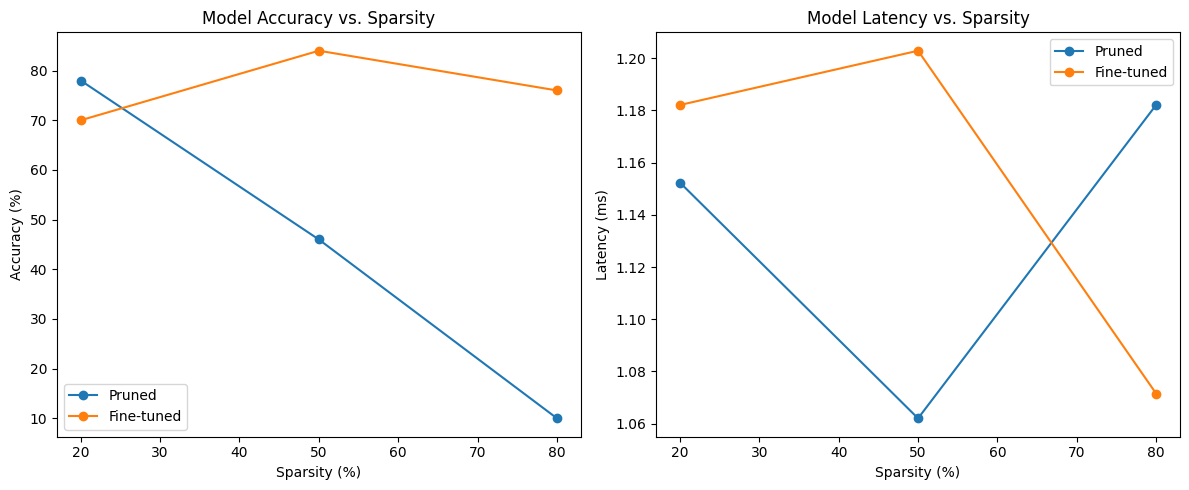

In [5]:
from models import CNNModel, load_dataset, test_transform
import torch

def calculate_sparsity(model):
	total_params = 0
	zero_params = 0

	for param in model.parameters():
		total_params += param.numel()
		zero_params += (param == 0).sum().item()

	sparsity = zero_params / total_params

	return sparsity

def calculate_latency(model):
	import time

	model.eval()

	dummy_input = torch.randn(1, 3, 32, 32)

	# warm-up
	for _ in range(10):
		_ = model(dummy_input)

	# measure latency
	sample_times = []

	for _ in range(90):
		start_time = time.perf_counter()
		_ = model(dummy_input)
		end_time = time.perf_counter()
		sample_times.append(end_time - start_time)

	avg_time = sum(sample_times) / len(sample_times)
	std_dev = (sum((t - avg_time) ** 2 for t in sample_times) / len(sample_times)) ** 0.5
	
	return avg_time, std_dev

def calculate_file_size(path):
	import os

	return os.path.getsize(path)

def evaluate_model(model, dataloader, path):
	model.load(path)
	model.eval()

	correct = 0
	total = 0

	with torch.no_grad():
		for images, labels in dataloader:
			outputs = model(images)
			_, predicted = torch.max(outputs.data, 1)
			total += len(labels)
			correct += (predicted == labels).sum().item()

	param_count = sum(p.numel() for p in model.parameters())
	param_count_nonzero = sum(p.nonzero().size(0) for p in model.parameters())

	print(f'Parameter Count: {param_count}, Non-zero Parameters: {param_count_nonzero}')

	accuracy = 100 * correct / total
	print(f'Accuracy: {accuracy:.2f}%')

	sparsity = calculate_sparsity(model)
	print(f'Sparsity: {sparsity * 100:.2f}%')

	latency, std_dev = calculate_latency(model)
	print(f'Latency: {latency * 1000:.2f} ms (+-{std_dev * 1000:.2f} ms)')

	file_size = calculate_file_size(path)
	print(f'File Size: {file_size / (1024 * 1024):.2f} MB')

	return accuracy, latency

_, dataloader = load_dataset('data/valid', test_transform, batch_size=1)

for name in ['cnn-original']:
	print(f'Evaluating {name}...')

	evaluate_model(CNNModel(), dataloader, f'checkpoints/{name}.pt')
	print('')

sparsities = [20, 50, 80]
accuracies = []
accuracies_finetuned = []
latencies = []
latencies_finetuned = []

for sparsity in sparsities:
	for finetuned in [False, True]:
		model_name = f'cnn-{"fine-tuned-" if finetuned else "pruned-"}{sparsity}%'
		print(f'Evaluating {model_name}...')

		accuracy, latency = evaluate_model(CNNModel(), dataloader, f'checkpoints/{model_name}.pt')
		print('')

		if finetuned:
			accuracies_finetuned.append(accuracy)
			latencies_finetuned.append(latency)
		else:
			accuracies.append(accuracy)
			latencies.append(latency)

# plots of accuracy and latency for both fine-tuned and non-fine-tuned models
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sparsities, accuracies, marker='o', label='Pruned')
plt.plot(sparsities, accuracies_finetuned, marker='o', label='Fine-tuned')
plt.xlabel('Sparsity (%)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Sparsity')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sparsities, [latency * 1000 for latency in latencies], marker='o', label='Pruned')
plt.plot(sparsities, [latency * 1000 for latency in latencies_finetuned], marker='o', label='Fine-tuned')
plt.xlabel('Sparsity (%)')
plt.ylabel('Latency (ms)')
plt.title('Model Latency vs. Sparsity')
plt.legend()

plt.tight_layout()
plt.show()